## (Optional) Mount folder in Colab

Uncomment thefollowing cell to mount your gdrive if you are using the notebook in google colab:

In [ ]:
# Use the following lines if you want to use Google Colab
# We presume you created a folder "i2dl" within your main drive folder, and put the exercise there.
# NOTE: terminate all other colab sessions that use GPU!
# NOTE 2: Make sure the correct exercise folder (e.g exercise_09) is given.

from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/i2dl/exercise_09'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present
print(sorted(os.listdir()))

# Relevant packages. NOTE: Be patient, it might take a few minutes.
!python -m pip install tensorboard==2.9.1 pytorch-lightning==1.6.0 torchtext


Mounted at /content/gdrive
['.tmp', '1_facial_keypoints.ipynb', 'Optional-spatial_batchnorm.ipynb', 'exercise_code', 'images', 'logs', 'models']
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 582.1/582.1 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 41.3 MB/s eta 0:00:00


# Facial Keypoint Detection

Welcome back for exercise 9! As we told you, the exercises of this lecture can be subdivided into mainly two parts. The first part in which we re-invented the wheel and implemented the most important methods on our own and the second part, where we start using existing libraries (that already have implemented all the methods). It's about time to start playing around with more complex network architectures. 

We've already entered stage two, but with the introduction of convolution neural networks this week, we are given a very powerful tool that we want to explore in this exercises. Therefore, in this week's exercise your task is to build a convolution neural network to perform facial keypoint detection. 

Before we start, let's take a look at some example images and corresponding facial keypoints:


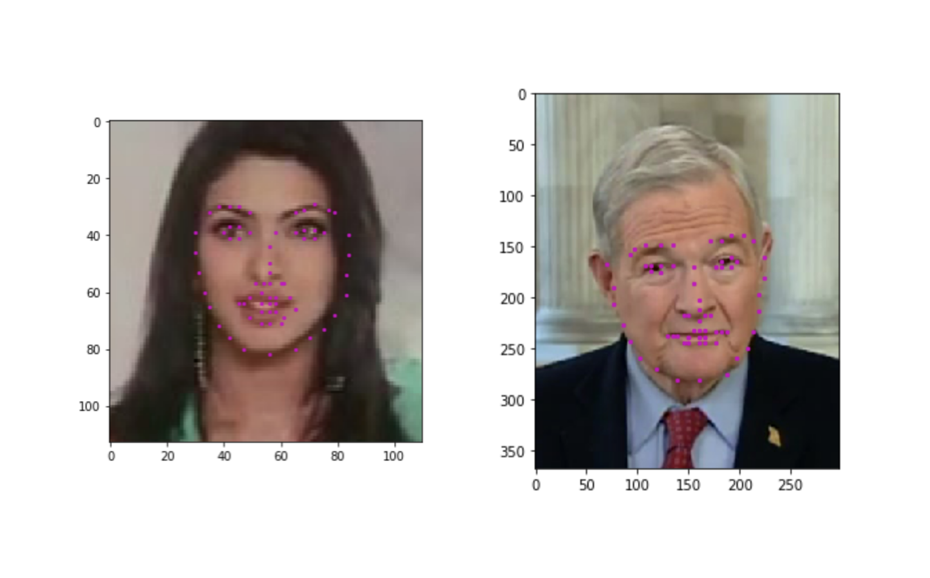

In [ ]:
from PIL import Image
Image.open('images/key_pts_example.png')

The facial keypoints (also called facial landmarks) are the small magenta dots shown on each of the faces in the images above. These keypoints mark important areas of the face: the eyes, corners of the mouth, the nose, etc. and are relevant for a variety of computer vision tasks, such as face filters, emotion recognition, pose recognition, and more. 

# 1. Preparation

## Imports

In [ ]:
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from exercise_code.data.facial_keypoints_dataset import FacialKeypointsDataset
from exercise_code.networks.keypoint_nn import (
    DummyKeypointModel,
    KeypointModel,
)
from exercise_code.util import (
    show_all_keypoints,
    save_model,
)
from exercise_code.tests import test_keypoint_nn

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

os.environ['KMP_DUPLICATE_LIB_OK']='True'

<div class="alert alert-warning">
    <h3>Note: Google Colab</h3>
    <p>
In case you don't have a GPU, you can run this notebook on Google Colab where you can access a GPU for free, but you can also run this notebook on your CPU.
         </p>
</div>

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Load and Visualize Data
To load the data, we have already prepared a Pytorch Dataset class `FacialKeypointsDataset` for you. You can find it in `exercise_code/data/facial_keypoints_dataset.py`. Run the following cell to download the data and initialize your dataset:

In [ ]:
download_url = "https://vision.in.tum.de/webshare/g/i2dl/facial_keypoints.zip"
i2dl_exercises_path = os.path.dirname(os.path.abspath(os.getcwd()))
data_root = os.path.join(i2dl_exercises_path, "datasets", "facial_keypoints")

train_dataset = FacialKeypointsDataset(
    train=True,
    transform=transforms.ToTensor(),
    root=data_root,
    download_url=download_url,
)

val_dataset = FacialKeypointsDataset(
    train=False,
    transform=transforms.ToTensor(),
    root=data_root,
)

print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))


Number of training samples: 1546
Number of validation samples: 298


Each sample in our dataset is a dict `{"image": image, "keypoints": keypoints}`, where
 * `image` is a [0-1]-normalized gray-scale image of size 96x96, represented by a torch tensor of shape (CxHxW) with C=1, H=96, W=96
   

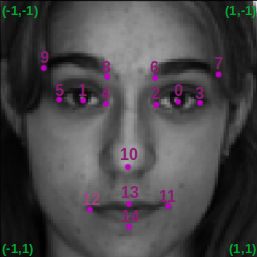

In [ ]:
 Image.open('images/key_pts_expl.png')

* `keypoints` is the list of K facial keypoints, stored in a torch tensor of shape (Kx2). We have K=15 keypoints that stand for:
   * keypoints[0]: Center of the left eye
   * keypoints[1]: Center of the right eye
   * keypoints[2]: Left eye inner corner
   * keypoints[3]: Left eye outer corner
   * keypoints[4]: Right eye inner corner
   * keypoints[5]: Right eye outer corner
   * keypoints[6]: Left eyebrow inner end
   * keypoints[7]: Left eyebrow outer end
   * keypoints[8]: Right eyebrow inner end
   * keypoints[9]: Right eyebrow outer end
   * keypoints[10]: Nose tip
   * keypoints[11]: Mouth left corner
   * keypoints[12]: Mouth right corner
   * keypoints[13]: Mouth center top lip
   * keypoints[14]: Mouth center bottom lip
   
Each individual facial keypoint is represented by two coordinates (x,y) that specify the horizontal and vertical location of the keypoint respectively. All keypoint values are normalized to [-1,1], such that:
   * (x=-1,y=-1) corresponds to the top left corner, 
   * (x=-1,y=1) to the bottom left corner,
   * (x=1,y=-1) to the top right corner,
   * (x=1,y=1) to the bottom right corner,
   * and (x=0,y=0) to the center of the image.
   
      
The data downloaded is already preprocessed and hence there is no need to apply transformations in order to prepare the data. Of course, feel free to apply training transformations to improve your performance such as e.g. flipping the training images. </br>

NOTE: Do not forget that these transformations (data augmentation) are only applied to your training data. Your validation and test set remain untouched. </br>

Also, when applying transformations such as flipping, make sure that the predicted coordinates of your keypoints change accordingly.

Let's have a look at the first training sample to get a better feeling for the dataset:

In [ ]:
image, keypoints = train_dataset[0]["image"], train_dataset[0]["keypoints"]
print("Shape of the image:", image.size())
print("Smallest value in the image:", torch.min(image))
print("Largest value in the image:", torch.max(image))
print(image)
print(keypoints)

Shape of the image: torch.Size([1, 96, 96])
Smallest value in the image: tensor(0.0118)
Largest value in the image: tensor(1.)
tensor([[[0.3804, 0.2039, 0.2275,  ..., 0.9922, 0.9961, 0.9961],
         [0.3333, 0.2157, 0.2588,  ..., 0.9922, 0.9961, 0.9961],
         [0.2941, 0.2588, 0.2902,  ..., 0.9922, 0.9961, 0.9961],
         ...,
         [0.1294, 0.1255, 0.1255,  ..., 0.9255, 1.0000, 1.0000],
         [0.1294, 0.1255, 0.1216,  ..., 0.9490, 0.9843, 0.9804],
         [0.1216, 0.1176, 0.1216,  ..., 0.9255, 1.0000, 0.9922]]])
tensor([[ 0.4685, -0.2319],
        [-0.4253, -0.1953],
        [ 0.2908, -0.2214],
        [ 0.5992, -0.2214],
        [-0.2685, -0.2109],
        [-0.5873, -0.1900],
        [ 0.1967, -0.3827],
        [ 0.7656, -0.4295],
        [-0.2035, -0.3758],
        [-0.7389, -0.3573],
        [ 0.0086,  0.2333],
        [ 0.4163,  0.6620],
        [-0.3521,  0.6985],
        [ 0.0138,  0.6045],
        [ 0.0190,  0.9076]])


In [ ]:
keypoints = train_dataset[0]["keypoints"]
print(keypoints)
keypoints.size()

tensor([[ 0.4685, -0.2319],
        [-0.4253, -0.1953],
        [ 0.2908, -0.2214],
        [ 0.5992, -0.2214],
        [-0.2685, -0.2109],
        [-0.5873, -0.1900],
        [ 0.1967, -0.3827],
        [ 0.7656, -0.4295],
        [-0.2035, -0.3758],
        [-0.7389, -0.3573],
        [ 0.0086,  0.2333],
        [ 0.4163,  0.6620],
        [-0.3521,  0.6985],
        [ 0.0138,  0.6045],
        [ 0.0190,  0.9076]])


torch.Size([15, 2])

In `exercise_code/util/vis_utils.py` we also provide you with a function `show_all_keypoints()` that takes in an image and keypoints and displays where the predicted keypoints are in the image. Let's use it to plot the first few images of our training set:

**Note:** if your kernel dies when running the following cell, please uncomment the last line of the imports cell `os.environ['KMP_DUPLICATE_LIB_OK']='True'`and try it again. 

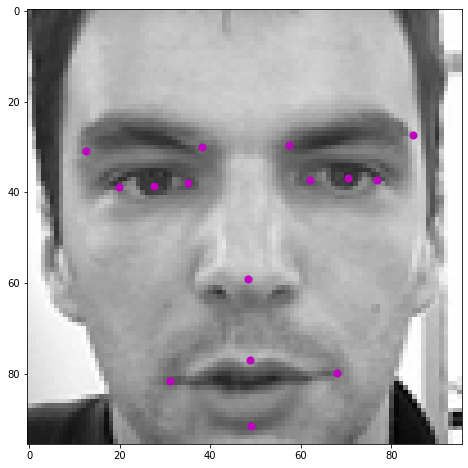

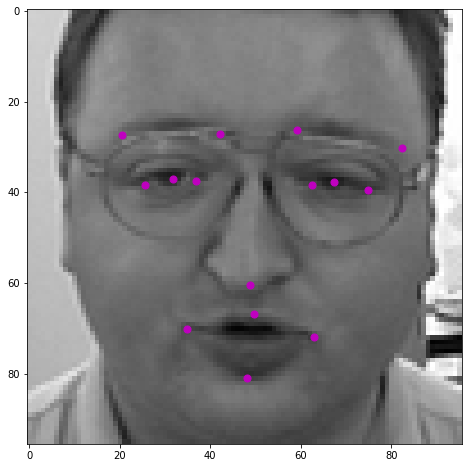

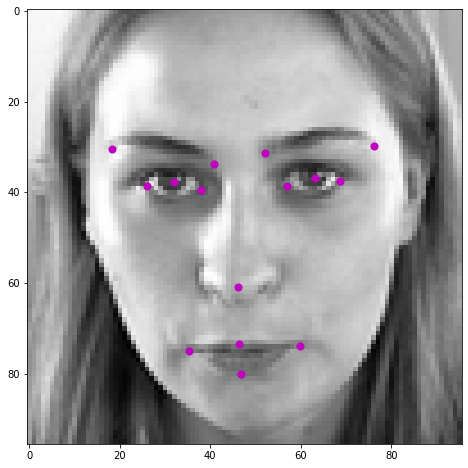

In [ ]:
def show_keypoints(dataset, num_samples=3):
    for i in range(num_samples):
        image = dataset[i]["image"]
        key_pts = dataset[i]["keypoints"]
        show_all_keypoints(image, key_pts)

show_keypoints(train_dataset)

# 2. Facial Keypoint Detection
Your task is to define and train a model for facial keypoint detection.

The facial keypoint detection task can be seen as a regression problem, where the goal is to predict 30 different values that correspond to the 15 facial keypoint locations. Thus, we need to build a network that gets a (1x96x96) image as input and predicts 30 continuous outputs between [-1,1].

## Dummy Model

<div class="alert alert-success">
    <h3>Task: Check Code</h3>
    <p>In <code>exercise_code/networks/keypoint_nn.py</code> we defined a naive <code>DummyKeypointModel</code>, which always predicts the keypoints of the first training image in the dataset. Let's try it on a few images and visualize our predictions in red:
 </p>
</div>

In [ ]:
def show_keypoint_predictions(model, dataset, num_samples=3):
    for i in range(num_samples):
        image = dataset[i]["image"].to(device)
        key_pts = dataset[i]["keypoints"].to(device)
        predicted_keypoints = torch.squeeze(model(image).detach()).view(15, 2)
        show_all_keypoints(image, key_pts, predicted_keypoints)

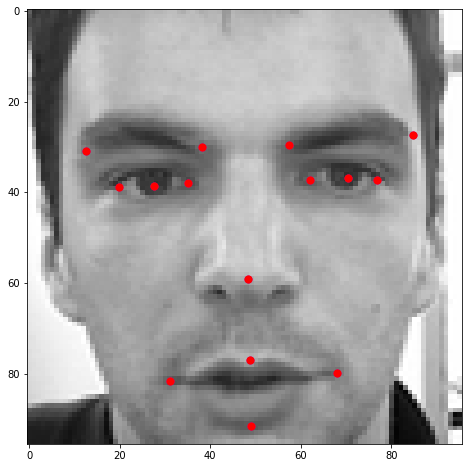

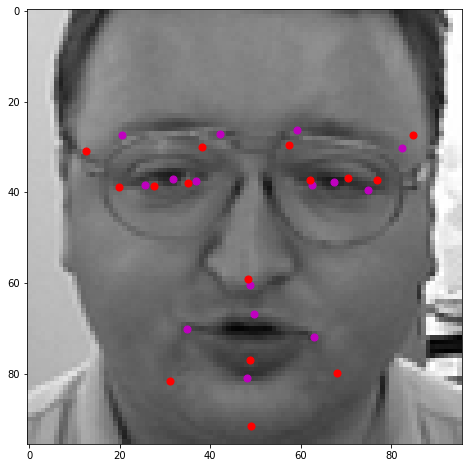

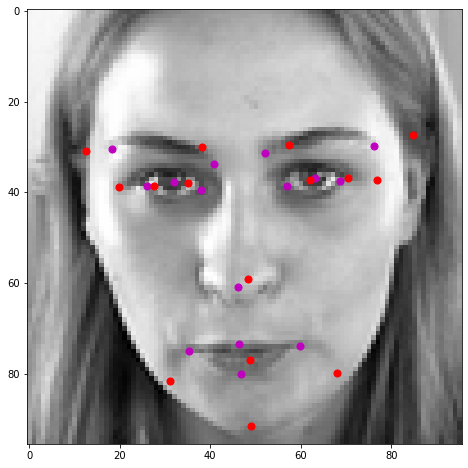

In [ ]:
dummy_model = DummyKeypointModel()
show_keypoint_predictions(dummy_model, train_dataset)

As we see, the model predicts the first sample perfectly, but for the remaining samples the predictions are quite off.

## Loss and Metrics

To measure the quality of the model's predictions, we will use the mean squared error (https://en.wikipedia.org/wiki/Mean_squared_error), summed up over all 30 keypoint locations. In PyTorch, the mean squared error is defined in `torch.nn.MSELoss()`, and we can use it like this:

In [ ]:
loss_fn = torch.nn.MSELoss()
for i in range(3):
    image = train_dataset[i]["image"]
    keypoints = train_dataset[i]["keypoints"]
    predicted_keypoints = torch.squeeze(dummy_model(image)).view(15, 2)
    loss = loss_fn(keypoints, predicted_keypoints)
    print("Loss on image %d:" % i, loss)

Loss on image 0: tensor(9.3016e-10)
Loss on image 1: tensor(0.0094)
Loss on image 2: tensor(0.0102)


As expected, our dummy model achieves a loss close to 0 on the first sample, but on all other samples the loss is quite high.

To obtain an evaluation score (in the notebook and on the submission server), we will use the following function:

In [ ]:
def evaluate_model(model, dataset):
    model.eval()
    model.to(device)
    criterion = torch.nn.MSELoss()
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    loss = 0
    for batch in dataloader:
        image, keypoints = batch["image"].to(device), batch["keypoints"].to(device)
        predicted_keypoints = model(image).view(-1, 15, 2).to(device)
        loss += criterion(
            torch.squeeze(keypoints), torch.squeeze(predicted_keypoints)
        ).item()
    return 1.0 / (2 * (loss / len(dataloader)))


print("Score of the Dummy Model:", evaluate_model(dummy_model, val_dataset))


Score of the Dummy Model: 60.19574441168827


**To pass the assignment, you will need to achieve a score of at least 100**. As you can see, the score is calculated from the average loss, so **your average loss needs to be lower than 0.005**. Our dummy model only gets a score of around 60, so you will have to come up with a better model.

## Step 1: Design your own model

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p> Now it is your turn to build your own model. To do so, you need to design a convolution neural network that takes images of size (Nx1x96x96) as input and produces outputs of shape (Nx30) in the range [-1,1]. Therefore, implement the <code>KeypointModel</code> class in <code>exercise_code/networks/keypoint_nn.py</code>.
    </p>
</div>

Recall that CNN's are defined by a few types of layers:
* Convolution layers
* Max-pooling layers
* Fully-connected layers

You can design your network however you want, but we strongly suggest to include multiple convolution layers. You are also encouraged to use things like dropout and batch normalization to stabilize and regularize your network. If you want to build a really competitive model, have a look at some literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf).

#### Define your model in the provided file 
`exercise_code/networks/keypoint_nn.py` file

This file is mostly empty but contains the expected class name, and the methods that your model needs to implement (only `forward()` basically). You are also free to decide whether you want to use PyTorch Lightning or not.
The only rules your model design has to follow are:
* Inherit from either `torch.nn.Module` or `pytorch_lightning.LightningModule`
* Perform the forward pass in forward(), predicting keypoints of shape (Nx30) for images of shape (Nx1x96x96)
* Have less than 5 million parameters
* Have a model size of less than 20MB after saving

Furthermore, you need to pass all your hyperparameters to the model in a single dictionary:

In [ ]:
# TODO: if you have any model arguments/hparams, define them here
hparams = {  
    "input_size": 1 * 96 * 96, # not used 
    "num_classes": 15,      # not used

    "epoch" : 50,
    "batch_size" : 32,   
    "learning_rate": 1e-4,
    "weight_decay": 1e-5,   # add L2 regularization 
    "num_workers": 2,       # not used, used by the dataloader, more workers means faster data preparation, but for us this is not a bottleneck here
}

To test whether your model follows the basic rules, run the following cell:

In [ ]:
model = KeypointModel(hparams)
test_keypoint_nn(model)

KeypointShapeTest passed.
ParamCountTest passed. Your model has 3.600 mio. params.
FileSizeTest passed. Your model is 14.4 MB large
All tests passed for your model. Tests passed: 3/3


## Step 2: Train your model

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p> In addition to the network itself, you will also need to write the code for the model training. You can use PyTorch Lightning for that, or you can also write it yourself in standard PyTorch.
    </p>
</div>

**Hints:**
* Use `torch.nn.MSELoss()` as loss function.

* You have two options for training code:
    - (Recommended) Use a straightforward training scheme. See 1.pytorch.ipynb from ex07.
    - (Not Recommended, especially for colab user) Use the Trainer() class, to utilize the beauty of pytorch-lightning. See 3.pytorch_lightning.ipynb from ex07. NOTE(!!!): To prevent a common bug, send the dataloaders to the trainer, and not to the pytorch-lightning class itself.
    - Don't call your model anything else besides "model", unless you notice that you'll need to modify the model name in the upcoming cells.
    - You could refer to the training scheme from exercise_08 to complete your code. Understanding this pipeline is crucial for future works in deep learning.
    

In [ ]:
from exercise_code.data.facial_keypoints_dataset import FacialKeypointsDataset
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import torch.optim as optim 
import torch
import numpy as np

########################################################################
# TODO - Train Your Model                                              #
########################################################################

######################
# Dataset            #
######################
train_dataset = FacialKeypointsDataset(
    train=True,
    transform=transforms.Compose([ transforms.ToTensor() ]),
    root=data_root,
    download_url=download_url,
)


val_dataset = FacialKeypointsDataset(
    train=False,
    transform=transforms.Compose([ transforms.ToTensor() ]),
    root=data_root,
)
######################
# Data Loader        #
######################
batch_size = hparams['batch_size'] # batch size 
train_loader = DataLoader(train_dataset, batch_size = batch_size, num_workers = 2)
val_loader = DataLoader(val_dataset, batch_size = batch_size,  num_workers = 2)


######################
# Early Stopper      #
######################
# https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch
# https://stackoverflow.com/questions/48029542/data-augmentation-in-test-validation-set
from exercise_code.networks.keypoint_nn import EarlyStopper
early_stopper = EarlyStopper(patience = 5, min_delta = 0)
early_stop_count = 0


##################################################################
# Initializing device model, optimizer, loss function            #
##################################################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device) # move the network to the current device 
optimizer = optim.Adam(model.parameters(), 
                        lr = hparams['learning_rate'], 
                        weight_decay = hparams['weight_decay'])
loss_function = torch.nn.MSELoss()


######################
# Plotting Func      #
######################
plt.rcParams['figure.figsize'] = (5, 4) # set default size of plots

def show_intermediate_keypoints(image, keypoints, pred_kpts=None):
    """Show image with predicted keypoints"""
    image = (image.clone() * 255).view(96, 96).cpu()
    plt.imshow(image, cmap='gray')

    if pred_kpts is not None:
      pred_kpts = pred_kpts.cpu()
      
    keypoints = (keypoints.clone() * 48 + 48).cpu()
    plt.scatter(keypoints[:, 0], keypoints[:, 1], s=200, marker='.', c='m')
    if pred_kpts is not None:
        pred_kpts = pred_kpts.clone() * 48 + 48
        plt.scatter(pred_kpts[:, 0], pred_kpts[:, 1], s=200, marker='.', c='r')
    plt.show()



#####################
# Training Function #
#####################
def get_num_batches(dataloader, data):
  return int(len(data)//dataloader.batch_size)

def fit(model, dataloader, data, tb_logger, name = 'train kpts'):
  model.train()
  train_running_loss = 0.0
  counter = 0 

  # calculate the number of batches 
  num_batches = get_num_batches(dataloader, data)
  
  for i, data in tqdm(enumerate(dataloader), total = num_batches):
    counter += 1
    image, keypoints = data['image'].to(device), data['keypoints'].to(device)

    optimizer.zero_grad()
    
    predicted = model(image).view(-1, 15, 2)
    loss = loss_function(predicted, keypoints)
    train_running_loss += loss.item()

    loss.backward()   # Perform a backward pass to calculate the gradients
    optimizer.step()  # Optimize the network parameters with calculated gradients

    # Update the tensorboard logger.
    tb_logger.add_scalar(f'{name}/train_loss', loss, epoch * len(train_loader) + i)

  train_loss = train_running_loss / counter
  return train_loss 


#######################
# Validation Function #
#######################
def validate(model, dataloader, data, epoch, tb_logger, name = 'val kpts'):
  model.eval()
  valid_running_loss = 0.0
  counter = 0

  # calculate the number of batches 
  num_batches = get_num_batches(dataloader, data)
  
  # not updating the weights 
  with torch.no_grad():
    for i, data in tqdm(enumerate(dataloader), total = num_batches):
      counter += 1
      image, keypoints = data['image'].to(device), data['keypoints'].to(device)
      
      predicted = model(image).view(-1, 15, 2)
      loss = loss_function(predicted, keypoints)
      valid_running_loss += loss.item()

      # Update the tensorboard logger.
      tb_logger.add_scalar(f'{name}/val_loss', loss, epoch * len(val_loader) + i)

      # draw the predicted kpts
      # if ( epoch+1 ) % 30 == 0 and i == 0:
      #   pred_kpts = torch.squeeze(predicted[0].detach()).view(15, 2)
      #   img = image[0]
      #   kpts = keypoints[0]
      #   show_intermediate_keypoints(img, kpts, pred_kpts)

  valid_loss = valid_running_loss / counter
  return valid_loss 


###############################################
# Executing Training and Validation Functions #
###############################################
# Creat a tensorboard logger.
# NOTE: In order to see the logs, run the following command in the terminal: tensorboard --logdir=./
# Also, in order to reset the logs, delete the logs folder MANUALLY.
path = os.path.join('logs', 'ae_logs')
num_of_runs = len(os.listdir(path)) if os.path.exists(path) else 0
path = os.path.join(path, f'run_{num_of_runs + 1}')
tb_logger = SummaryWriter(path)

train_loss = []
val_loss = []
epochs = hparams['epoch']

for epoch in range(epochs):
  train_epoch_loss = fit(model, train_loader, train_dataset, tb_logger)
  val_epoch_loss = validate(model, val_loader, val_dataset, epoch, tb_logger)
  train_loss.append(train_epoch_loss)
  val_loss.append(val_epoch_loss)
  
  print()
  print(f'Epoch : {epoch + 1} / {epochs} :: Train Loss: {train_epoch_loss:.8f} / Validation Loss: {val_epoch_loss:.8f} ')


########################################################################
#                           END OF YOUR CODE                           #
########################################################################


49it [00:12,  3.96it/s]                        
10it [00:00, 17.32it/s]                      


Epoch : 1 / 50 :: Train Loss: 0.99500348 / Validation Loss: 0.37544908 



49it [00:02, 18.69it/s]                        
10it [00:00, 17.33it/s]                      


Epoch : 2 / 50 :: Train Loss: 0.60412644 / Validation Loss: 0.21253502 



49it [00:02, 18.40it/s]                        
10it [00:00, 17.88it/s]                      


Epoch : 3 / 50 :: Train Loss: 0.42162679 / Validation Loss: 0.13825688 



49it [00:02, 18.63it/s]                        
10it [00:00, 17.52it/s]                      


Epoch : 4 / 50 :: Train Loss: 0.32133191 / Validation Loss: 0.08961384 



49it [00:02, 18.81it/s]                        
10it [00:00, 16.21it/s]                      


Epoch : 5 / 50 :: Train Loss: 0.25369916 / Validation Loss: 0.05932152 



49it [00:02, 18.19it/s]                        
10it [00:00, 17.83it/s]                      


Epoch : 6 / 50 :: Train Loss: 0.21553729 / Validation Loss: 0.04429247 



49it [00:02, 19.07it/s]
10it [00:00, 16.86it/s]                      


Epoch : 7 / 50 :: Train Loss: 0.18258671 / Validation Loss: 0.03433740 



49it [00:02, 19.11it/s]                        
10it [00:00, 17.96it/s]                      


Epoch : 8 / 50 :: Train Loss: 0.16353589 / Validation Loss: 0.02673376 



49it [00:02, 18.20it/s]                        
10it [00:00, 18.08it/s]                      


Epoch : 9 / 50 :: Train Loss: 0.15029923 / Validation Loss: 0.02140817 



49it [00:02, 18.57it/s]                        
10it [00:00, 17.53it/s]                      


Epoch : 10 / 50 :: Train Loss: 0.13569544 / Validation Loss: 0.01815663 



49it [00:02, 18.76it/s]                        
10it [00:00, 17.85it/s]                      


Epoch : 11 / 50 :: Train Loss: 0.12561050 / Validation Loss: 0.01615954 



49it [00:02, 18.97it/s]                        
10it [00:00, 18.13it/s]                      


Epoch : 12 / 50 :: Train Loss: 0.11909245 / Validation Loss: 0.01488572 



49it [00:02, 18.90it/s]
10it [00:00, 18.07it/s]                      


Epoch : 13 / 50 :: Train Loss: 0.11189461 / Validation Loss: 0.01215765 



49it [00:02, 19.14it/s]
10it [00:00, 17.86it/s]                      


Epoch : 14 / 50 :: Train Loss: 0.10761648 / Validation Loss: 0.01240483 



49it [00:02, 18.72it/s]                        
10it [00:00, 17.67it/s]                      


Epoch : 15 / 50 :: Train Loss: 0.10341521 / Validation Loss: 0.00956736 



49it [00:02, 18.88it/s]                        
10it [00:00, 18.05it/s]                      


Epoch : 16 / 50 :: Train Loss: 0.09883609 / Validation Loss: 0.00928876 



49it [00:02, 18.48it/s]                        
10it [00:00, 18.88it/s]                      


Epoch : 17 / 50 :: Train Loss: 0.09649988 / Validation Loss: 0.00830472 



49it [00:02, 18.90it/s]                        
10it [00:00, 17.81it/s]                      


Epoch : 18 / 50 :: Train Loss: 0.09288039 / Validation Loss: 0.00840892 



49it [00:02, 18.98it/s]
10it [00:00, 17.11it/s]                      


Epoch : 19 / 50 :: Train Loss: 0.09174340 / Validation Loss: 0.00761979 



49it [00:02, 18.88it/s]                        
10it [00:00, 17.80it/s]                      


Epoch : 20 / 50 :: Train Loss: 0.08909650 / Validation Loss: 0.00685116 



49it [00:02, 18.24it/s]
10it [00:00, 16.90it/s]                      


Epoch : 21 / 50 :: Train Loss: 0.08594900 / Validation Loss: 0.00670206 



49it [00:02, 18.99it/s]                        
10it [00:00, 18.36it/s]                      


Epoch : 22 / 50 :: Train Loss: 0.08173852 / Validation Loss: 0.00612990 



49it [00:03, 14.01it/s]                        
10it [00:00, 14.91it/s]                      


Epoch : 23 / 50 :: Train Loss: 0.07901044 / Validation Loss: 0.00631292 



49it [00:02, 18.75it/s]                        
10it [00:00, 16.17it/s]                      


Epoch : 24 / 50 :: Train Loss: 0.08086648 / Validation Loss: 0.00623576 



49it [00:02, 18.69it/s]                        
10it [00:00, 17.76it/s]                      


Epoch : 25 / 50 :: Train Loss: 0.07757172 / Validation Loss: 0.00607978 



49it [00:02, 18.95it/s]
10it [00:00, 18.35it/s]                      


Epoch : 26 / 50 :: Train Loss: 0.07448275 / Validation Loss: 0.00540212 



49it [00:02, 19.10it/s]                        
10it [00:00, 18.07it/s]                      



Epoch : 27 / 50 :: Train Loss: 0.07520119 / Validation Loss: 0.00535882 


49it [00:02, 18.81it/s]                        
10it [00:00, 17.82it/s]                      


Epoch : 28 / 50 :: Train Loss: 0.07472565 / Validation Loss: 0.00514968 



49it [00:02, 19.36it/s]                        
10it [00:00, 17.40it/s]                      


Epoch : 29 / 50 :: Train Loss: 0.07132304 / Validation Loss: 0.00497392 



49it [00:02, 19.45it/s]                        
10it [00:00, 17.87it/s]                      


Epoch : 30 / 50 :: Train Loss: 0.07192338 / Validation Loss: 0.00490578 



49it [00:02, 19.16it/s]                        
10it [00:00, 18.29it/s]                      


Epoch : 31 / 50 :: Train Loss: 0.06946252 / Validation Loss: 0.00517119 



49it [00:02, 18.81it/s]                        
10it [00:00, 15.85it/s]                      


Epoch : 32 / 50 :: Train Loss: 0.06620582 / Validation Loss: 0.00492266 



49it [00:02, 18.97it/s]                        
10it [00:00, 17.09it/s]                      


Epoch : 33 / 50 :: Train Loss: 0.06516921 / Validation Loss: 0.00460550 



49it [00:03, 13.69it/s]
10it [00:00, 17.67it/s]                      


Epoch : 34 / 50 :: Train Loss: 0.06673942 / Validation Loss: 0.00504010 



49it [00:02, 18.48it/s]                        
10it [00:00, 17.91it/s]                      


Epoch : 35 / 50 :: Train Loss: 0.06682473 / Validation Loss: 0.00425204 



49it [00:02, 18.34it/s]                        
10it [00:00, 17.90it/s]                      


Epoch : 36 / 50 :: Train Loss: 0.06559206 / Validation Loss: 0.00485972 



49it [00:02, 18.39it/s]                        
10it [00:00, 16.75it/s]                      


Epoch : 37 / 50 :: Train Loss: 0.06474066 / Validation Loss: 0.00457579 



49it [00:02, 18.54it/s]                        
10it [00:00, 17.99it/s]                      


Epoch : 38 / 50 :: Train Loss: 0.06222170 / Validation Loss: 0.00498953 



49it [00:02, 18.78it/s]                        
10it [00:00, 17.60it/s]                      


Epoch : 39 / 50 :: Train Loss: 0.06249734 / Validation Loss: 0.00467283 



49it [00:02, 18.57it/s]                        
10it [00:00, 17.31it/s]                      


Epoch : 40 / 50 :: Train Loss: 0.06167653 / Validation Loss: 0.00457977 



49it [00:02, 18.21it/s]                        
10it [00:00, 17.81it/s]                      


Epoch : 41 / 50 :: Train Loss: 0.05857477 / Validation Loss: 0.00459963 



49it [00:02, 19.08it/s]                        
10it [00:00, 18.62it/s]                      


Epoch : 42 / 50 :: Train Loss: 0.05917259 / Validation Loss: 0.00421022 



49it [00:02, 18.75it/s]                        
10it [00:00, 16.66it/s]                      


Epoch : 43 / 50 :: Train Loss: 0.05731311 / Validation Loss: 0.00455689 



49it [00:02, 18.15it/s]                        
10it [00:00, 18.63it/s]                      


Epoch : 44 / 50 :: Train Loss: 0.05688912 / Validation Loss: 0.00413673 



49it [00:02, 19.10it/s]                        
10it [00:00, 17.97it/s]                      


Epoch : 45 / 50 :: Train Loss: 0.05519767 / Validation Loss: 0.00418207 



49it [00:02, 19.44it/s]
10it [00:00, 17.86it/s]                      


Epoch : 46 / 50 :: Train Loss: 0.05375793 / Validation Loss: 0.00392993 



49it [00:02, 19.17it/s]
10it [00:00, 17.63it/s]                      


Epoch : 47 / 50 :: Train Loss: 0.05172685 / Validation Loss: 0.00386410 



49it [00:02, 19.16it/s]                        
10it [00:00, 17.54it/s]                      


Epoch : 48 / 50 :: Train Loss: 0.05396867 / Validation Loss: 0.00426417 



49it [00:02, 19.15it/s]                        
10it [00:00, 18.34it/s]                      


Epoch : 49 / 50 :: Train Loss: 0.05262467 / Validation Loss: 0.00432477 



49it [00:02, 18.70it/s]                        
10it [00:00, 17.84it/s]


Epoch : 50 / 50 :: Train Loss: 0.05095040 / Validation Loss: 0.00436875 


When you're done training, run the cells below to visualize some predictions of your model, and to compute a validation score:

In [ ]:
import torchsummary 

torchsummary.summary(model, (1, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 93, 93]             272
       BatchNorm2d-2           [-1, 16, 93, 93]              32
              ReLU-3           [-1, 16, 93, 93]               0
         MaxPool2d-4           [-1, 16, 46, 46]               0
         Dropout2d-5           [-1, 16, 46, 46]               0
            Conv2d-6           [-1, 32, 44, 44]           4,640
       BatchNorm2d-7           [-1, 32, 44, 44]              64
              ReLU-8           [-1, 32, 44, 44]               0
         MaxPool2d-9           [-1, 32, 22, 22]               0
        Dropout2d-10           [-1, 32, 22, 22]               0
           Conv2d-11           [-1, 64, 21, 21]           8,256
      BatchNorm2d-12           [-1, 64, 21, 21]             128
             ReLU-13           [-1, 64, 21, 21]               0
        MaxPool2d-14           [-1, 64,

In [ ]:
def show_keypoint_predictions(model, dataset, num_samples=3):
    for i in range(num_samples):
        image = dataset[i]["image"].to(device)
        key_pts = dataset[i]["keypoints"].to(device)
        predicted_keypoints = torch.squeeze(model(image).detach()).view(15, 2)
        show_all_keypoints(image, key_pts, predicted_keypoints)

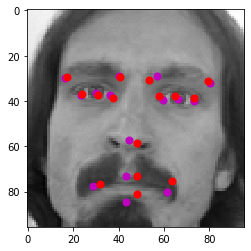

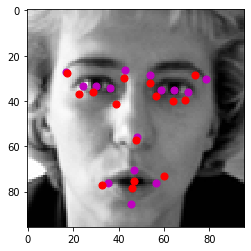

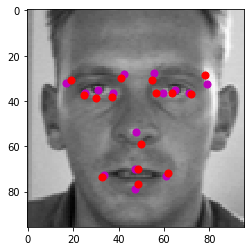

In [ ]:
show_keypoint_predictions(model, val_dataset)

In [ ]:
print("Score:", evaluate_model(model, val_dataset))

Score: 115.23937042031966


# 3. Save Your Model for Submission

If your model achieved a validation score of 100 or higher, save your model with the cell below and submit it to [the submission server](https://i2dl.vc.in.tum.de/). Your validation set is of course different from the test set on our server, so results may vary. Nevertheless, you will have a reasonable close approximation about your performance.

Before that, we will check again whether the number of parameters is below 5 Mio. and the file size is below 20 MB.

In [ ]:
save_model(model, "facial_keypoints.p")

'models/facial_keypoints.p'

Congrats - you've now finished your first Convolution Neural Network! Simply run the following cell to create a zipped file for your implementations.

In [ ]:
# Now zip the folder for upload
from exercise_code.util.submit import submit_exercise

submit_exercise("../output/exercise09")


relevant folders: ['exercise_code', 'models']
notebooks files: ['Optional-spatial_batchnorm.ipynb', '1_facial_keypoints.ipynb']
Adding folder exercise_code
Adding folder models
Adding notebook Optional-spatial_batchnorm.ipynb
Adding notebook 1_facial_keypoints.ipynb
Zipping successful! Zip is stored under: /content/gdrive/MyDrive/i2dl/output/exercise09.zip


# Submission Goals

- Goal: Implement and train a convolution neural network for facial keypoint detection.
- Passing Criteria: Reach **Score >= 100** on __our__ test dataset. The submission system will show you your score after you submit.

- Submission start: __January 12, 2023, 13.00__
- Submission deadline: __January 18, 2023 - 15:59__ 
- You can make **$\infty$** submissions until the deadline. Your __best submission__ will be considered for bonus

# [Exercise Review](https://docs.google.com/forms/d/e/1FAIpQLSedSHEJ5vN-9FmJN-IGSQ9heDM_8qJQjHL4glgQGlrpQJEYPQ/viewform?usp=pp_url&entry.999074405=Exercise+9:+Facial+Keypoints)
We are always interested in your opinion. Now that you have finished this exercise, we would like you to give us some feedback about the time required to finish the submission and/or work through the notebooks. Please take the short time to fill out our [review form](https://docs.google.com/forms/d/e/1FAIpQLSedSHEJ5vN-9FmJN-IGSQ9heDM_8qJQjHL4glgQGlrpQJEYPQ/viewform?usp=pp_url&entry.999074405=Exercise+9:+Facial+Keypoints) for this exercise so that we can do better next time! :)